# Seasonal SBAS Stacks

SBAS time series analyses require a coherent, fully-connected, redundant stack of interferograms with small perpendicular and temporal baselines.

Seasonal impacts to scatterers often break coherence, making it difficult to prepare long time series for MintPy. In these cases, it may possible to create a seasonal stack, removing seasons that would cause a loss of coherence. 

To avoid creating a disconnected stack, seasonal gaps can be bridged with interferograms having one-year temporal baselines.

---
## Define seasonal SBAS stack parameters

In [ ]:
# This does not need to be the first scene in the stack. 
# slc_id = 'S1A_IW_SLC__1SDV_20200519T004428_20200519T004455_032627_03C760_27C2
slc_id = 'S1A_IW_SLC__1SDV_20180611T004417_20180611T004444_022302_0269F0_974B'
slc_id = 'S1_342203_IW1_20180609T161146_VV_7F78-BURST'

# mm-dd
season_start_date = '5-15'
season_end_date = '9-15'

# yyyy-mm-dd
stack_start_date = '2018-01-01'
stack_end_date = '2020-12-31'

max_temporal_baseline = 36
max_perp_baseline = 100

# Helps determine the expected number of pairs for a given temporal baseline threshold when bridging seasons
repeat_pass_freq = 12

---
## Build an SBASStack object

- If the `season`, `start`, `end`, and `refSceneName` args are passed upon initialization, an SBAS stack will be immediately calculated using default repeat pass frequency and baselines
- Parameters can be added or adjusted, generating updated SBAS stacks

Baseline and repeat pass frequency defaults:
- `perpendicularBaseline`: 400
- `temporBaseline`: 36
- `repeatPassFrequency`: 12
- `perpBaselineShortcut`: True

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import asf_search as asf

args = {
    'season': (season_start_date, season_end_date), 
    'start': stack_start_date, 
    'end': stack_end_date, 
    'refSceneName': slc_id,
    'perpendicularBaseline': max_perp_baseline,
    'temporalBaseline': max_temporal_baseline,
    # 'repeatPassFrequency': 12,
    # 'overlapThreshold': 0.8,
    # 'perpBaselineShortcut': True
}

sbas = asf.ASFSBASStack(**args)

## Plot the Stack with the perpendicular baseline shortcut turned on

This will generate an SBAS stack quickly but may exclude some scenes that meet the perpendicular baseline constraint. Instead of using the perpendicular baseline between each scene pair, the perpendicular baseline for every scene in the stack is referenced against the stack's reference scene. This approach and is much faster as it requires only a single API call to build a stack. 

In [ ]:
sbas.perp_baseline_shortcut = True
sbas.plot()

https://search.asf.alaska.edu/#/?zoom=3.000&center=-72.204,-4.422&searchType=SBAS%20Search&searchList=S1_342203_IW1_20170720T161142_VV_DF0C-BURST&resultsLoaded=true&granule=S1_342203_IW1_20141028T161127_VV_49E4-BURST&master=S1_342203_IW1_20180609T161146_VV_7F78-BURST&perp=0to104&temporal=1to36&selectedPair=S1_342203_IW1_20180516T161145_VV_41D6-BURST,S1_342203_IW1_20180528T161146_VV_A10E-BURST&seasonStart=135&seasonEnd=258&start=2018-01-01T09:00:00Z&end=2021-01-01T08:59:59Z

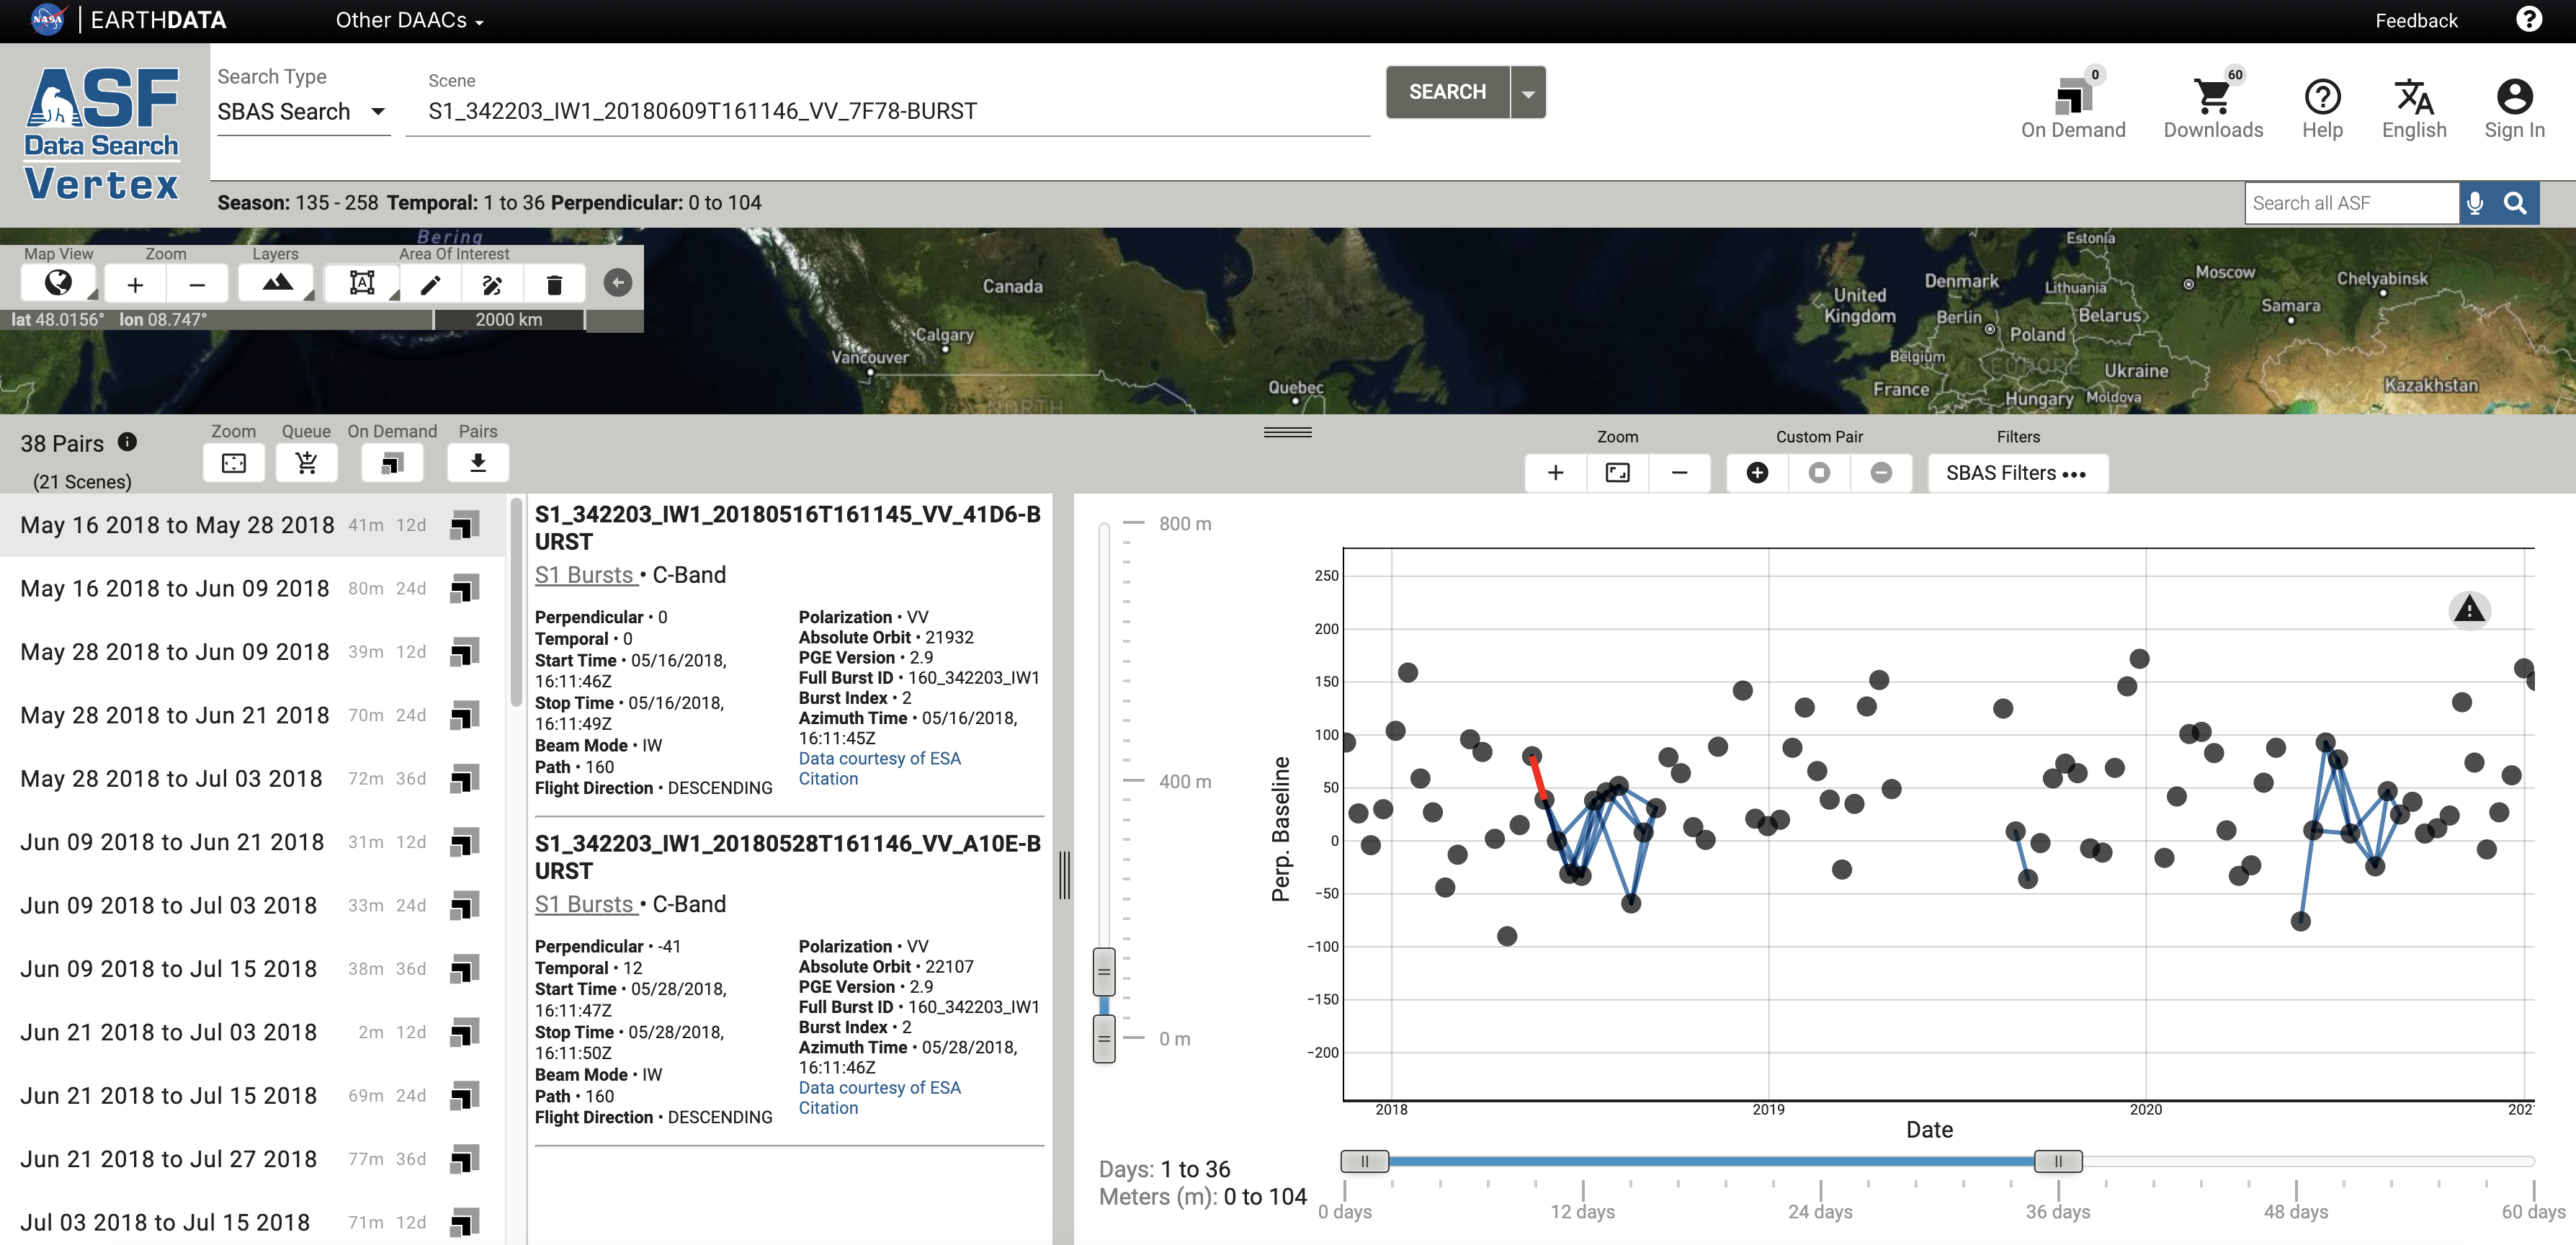

## Turn off the perpendicular baseline shortcut and replot

To find the perpendicular baselines for each pair in the stack, a stack search must be performed for every scene in the SBAS stack.

This more accurate approach is slower but may include additional pairs.

In [ ]:
sbas.perp_baseline_shortcut = False
sbas.plot()

## Turn the baseline shortcut back on and extend the length of the time series

In [ ]:
sbas.perp_baseline_shortcut = True
sbas.end = '2023-11-01'
sbas.plot()

In [ ]:
sbas.sbas_stack

---
## Adjust the temporal baseline and re-plot

In [ ]:
sbas.temporal_baseline = 48
sbas.plot()

## Change the SBAS stack's reference scene

In [ ]:
sbas.ref_scene_id = 'S1_213521_IW1_20180524T133605_VV_227D-BURST'
sbas.plot()

In [ ]:
sbas.perp_baseline = 400
sbas.plot()

---
## Create a list of scene IDs for each InSAR pair to submit as HyP3 On-Demand Processing jobs

In [ ]:
insar_pairs = sbas.get_insar_pairs()
print(f'InSAR Pairs: {len(insar_pairs)}')

---
## Authenticate with HyP3 using your EarthData Login Credentials

In [ ]:
import hyp3_sdk as sdk
hyp3 = sdk.HyP3(prompt=True)

---
## Define a HyP3 project name for your SBAS stack

In [ ]:
project_name = input("Enter a HyP3 project name")

---
## Request the interferograms

In [ ]:
job_type = 'INSAR_ISCE_BURST' if 'BURST' in sbas.ref_scene_id else 'INSAR_GAMMA'

insar_jobs = sdk.Batch()
for pair in insar_pairs:
    if job_type == 'INSAR_GAMMA':
        insar_jobs += hyp3.submit_insar_job(pair[0], pair[1], name=project_name)
    else:
        insar_jobs += hyp3.submit_insar_isce_burst_job(pair[0], pair[1], name=project_name)
print(insar_jobs)

In [ ]:
insar_jobs = hyp3.watch(insar_jobs)